### Searching for **Top** Electricity Consumers with
# (ﾉ◕ヮ◕)ﾉ*:･ﾟ✧ *MapReduce*

<br><br><br>
_________________________
<br>

#### Learning How to **Scale Up**
If you collect lots of data on customers or users on a single server you sooner or later do not only encounter depleted storage capacities but also long computing times whenever you process that data, even with simple processing tasks, such as filtering (e.g. you don´t want punctuation in your data)

When you handle big data it is therefore a no-brainer to leverage computer clusters where your data and your tasks are distributed on multiple servers (aka nodes) that work together. There are nowadays libraries like Spark or Dask that scale and parallelize your code to run on clusters but there are also programming paradigms with which you can write your tasks, your code in a way that is scalable. One of those paradigms is **MapReduce** which is especially used for simple pre-processing tasks on massive data.

This will be another tool for you to learn and use whenever you want to scale up your programs.

<br><br>
______
<br>

### **The Scenario**
You are a Data Analyst in a renowned European electricity provider and your manager tells you that he will have an important meeting with an external partner where he needs to present the **top customers by average daily electricity consumption per year**.

This is the data that you are looking at:

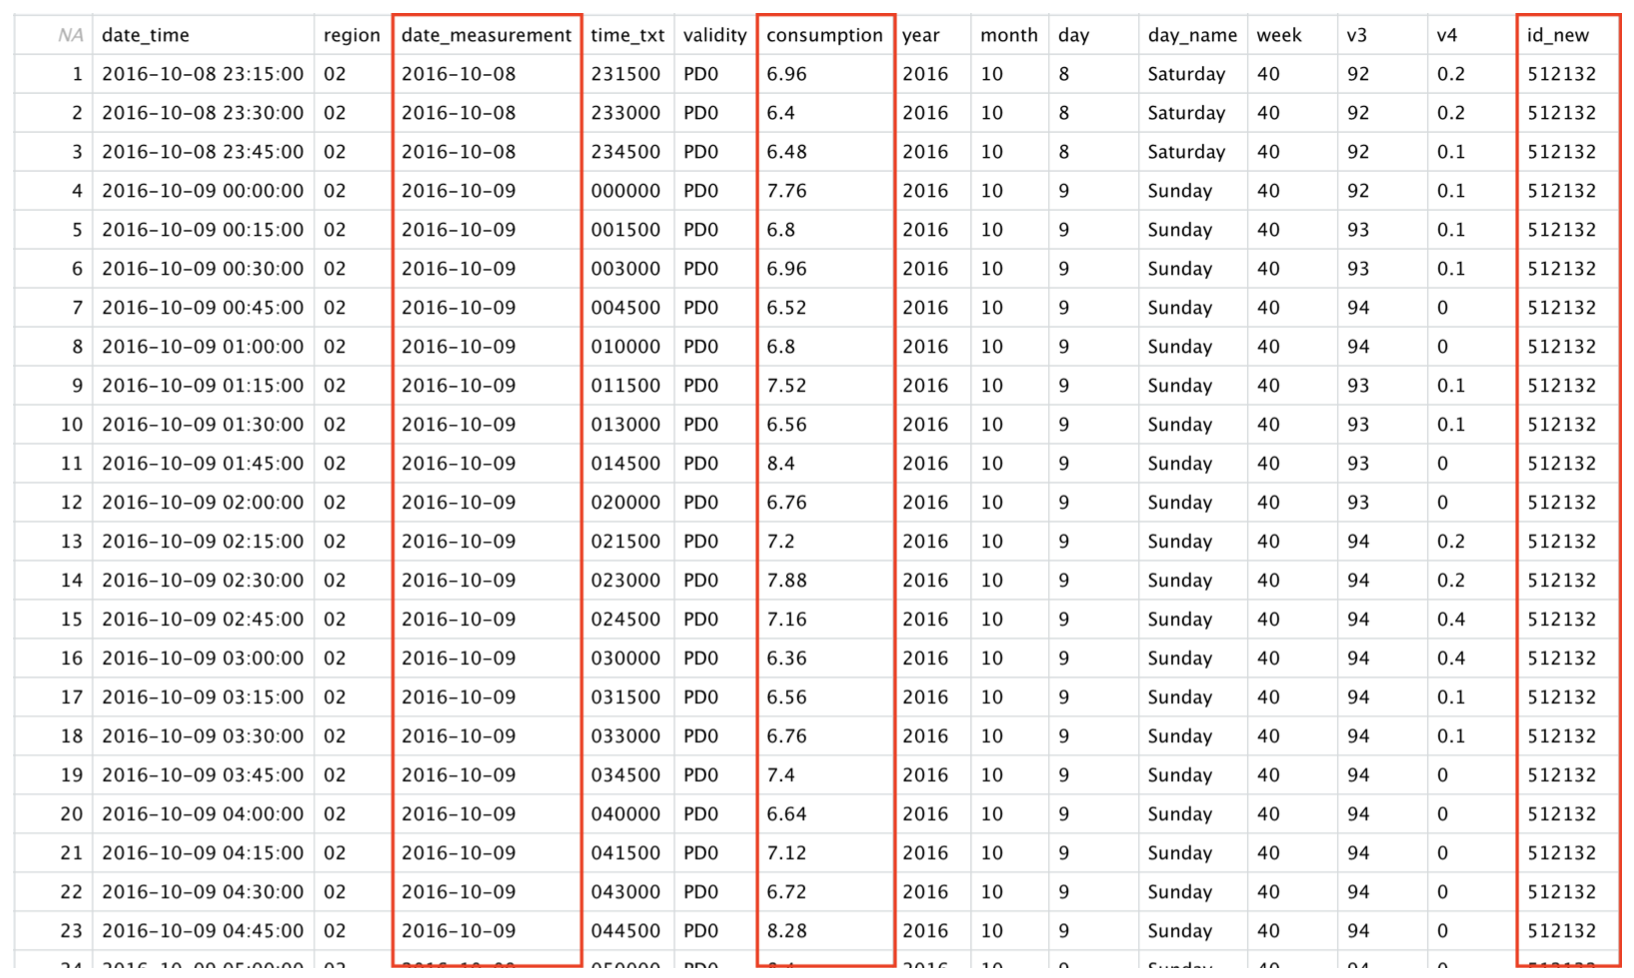


The electricity consumption is in the column "consumption" and the customer identification number is in the column "id_new" (this had to be pseudonymized as it is an external meeting. The consumption is recorded every 15 minutes, which can be seen in the "date_time" column. 


So, to recapitulate, what is your task? 

### #TODO

1. You will first need to sum up the electricity consumption of each day for every customer. 
2. Then sum up the electricity consumption of each year for every customer.
3. Print the top ten average daily consumptions (they don´t necessarily have to be from different customers).

You will probably need to write two mapreduce jobs to complete this task (unless you come up with a smarter way). This is called job chaining, where you give the output of the first job as input for the second job. 


For your task you will be interested in following columns:
- date_measurement
- consumption
- id_new


The first mapreduce job will be a tutorial where you can see how it works but you will need to write the second job by yourself or even better with your fellow data analyst colleagues in a breakout room! 


<br><br>

___

To understand what we need to write in order to submit a mapreduce job to the cluster, lets have a look at the submit command (which can be found in the [Start MapReduce Job](#start_mapred) cell):

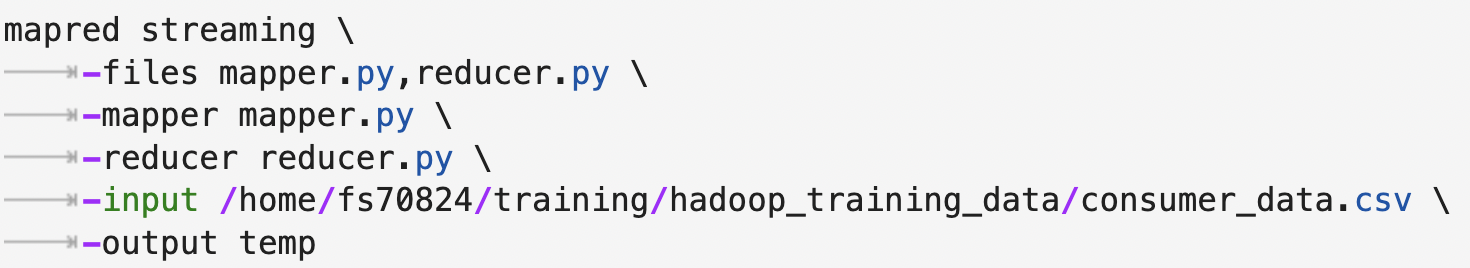

So, we can see that we need two files: mapper.py,reducer.py

mapper.py is a python file that we will write the mapper function in and reducer.py corresponds to the reducer function. The input parameter is also important, here we denote the file that will be read, which is our electricity consumption data (consumer_data.csv) and the output of the reducer file will then be written into the folder temp which will be created upon processing the job. 

<br><br>

___

## ･ﾟ✧ First *MapReduce* Job ✧･ﾟ

#### The first Mapper 

Following is the structure of the first mapper function. The way mapreduce works is that the first function of the framework, the split function, splits the entire data into its rows and distributes them on all nodes. 
**So each input (coming from the input stream STDIN = standard input)is treated as a single line of the data. Do not forget this!**


You will first need to split a line (or row) coming from the input stream into its words (aka columns) and return the customer ID + the data as key and the electricity consumption as value.

In [1]:
%%writefile mapper.py
#!/bin/python3
import sys

# input comes from STDIN (standard input)
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()
    # split the line into words
    words = line.split(",")

    # key: constructing the customerID_date key by concatenating the
    # value of the last element (column) which is the ID and the 
    # fourth element which is the date
    # value: the consumption of a time interval in a day, which is 
    # seventh element
    customerID_date= words[-1] + "_" + words[3]
    consumptionPerDay = words[6]

    # printing the key and the value to STDOUT
    # this line will be sorted before passed to reducer
    print("{}\t{}".format(customerID_date, consumptionPerDay))

Overwriting mapper.py


You can check the file "mapper.py" in your directory.
_____

#### The first Reducer 

Following is the structure of the first reducer function, which is similar to the mapper.

You will again need to split the line into its words (aka columns).

In [2]:
%%writefile reducer.py
#!/bin/python3
from operator import itemgetter
import sys

currentCustomer = None
currentConsumption = 0
consumption = None

# input comes from STDIN
for line in sys.stdin:

    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from mapper.py
    customerID_date, consumptionPerDay = line.split("\t", 1)

    # convert consumptionPerDay (currently a string) to int
    try:
        consumptionPerDay = int(consumptionPerDay)
    except ValueError:
        # consumptionPerDay was not a number, so silently
        # ignore/discard this line
        continue

    # this IF-switch only works because Hadoop sorts map output
    # by key (here: customerID_date) before it is passed to the reducer
    if currentCustomer == customerID_date:
        currentConsumption += consumptionPerDay
    else:
        if currentConsumption:
            # we write the result of the previous customer to STDOUT
            print("{}\t{}".format(currentCustomer, currentConsumption))
        # we set a new currentCustomer and a new currentConsumption
        currentConsumption = consumptionPerDay
        currentCustomer = customerID_date

#printing the very last customer also to STDOUT
if currentCustomer == customerID_date:
    print("{}\t{}".format(currentCustomer, currentConsumption))

Overwriting reducer.py


### Test Job Submission

In [3]:
%%writefile TEST_start_mapred_job.slrm
#!/bin/bash
#SBATCH -J mapred_test
#SBATCH -N 1
#SBATCH --partition=skylake_0096
#SBATCH --qos=skylake_0096
#SBATCH --reservation=training # available only during course
#SBATCH --time=00:03:00


module load hadoop 
rm -rf temp

mapred streaming \
	-files mapper.py,reducer.py \
	-mapper mapper.py \
	-reducer reducer.py \
	-input /home/fs70824/training/hadoop_training_data/consumer_data.csv \
	-output temp

Overwriting TEST_start_mapred_job.slrm


In [4]:
!sbatch TEST_start_mapred_job.slrm # submit the job

Submitted batch job 39230


In [5]:
!squeue -u $USER # check status of your job

             JOBID            PARTITION     NAME     USER ST       TIME  NODES     NODELIST(REASON)
             38529         skylake_0096 vsc4_jh_ trainee2  R    5:11:01      1            n4901-003
             39230         skylake_0096 mapred_t trainee2  R    INVALID      1            n4901-018


You can check the output of the mapreduce job under the folder *temp*.
A \_SUCCESS file indicates that the job has run successfully and the file/s starting with "part" contain/s the output.

In [7]:
!head -10 temp/part-00000 

1018508_2016-10-19	12
1018508_2016-10-20	14
1018508_2016-10-21	14
1018508_2016-10-23	4
1018508_2016-10-25	16
1018508_2016-10-30	4
1018508_2016-11-03	11
1018508_2016-11-05	36
1018508_2016-11-06	4
1018508_2016-11-08	25



## ･ﾟ✧ Second *MapReduce* Job ✧･ﾟ


#### The second Mapper

In [8]:
%%writefile second_mapper.py
#!/bin/python3

import sys

# input comes from STDIN (standard input)
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from reducer.py
    # omit the day in the customerID_date
    customerID_date, consumptionPerDay = line.split("\t", 1)
    customerID_date = customerID_date.split("-",1)[0]

    # return customerID_date as key and the consumption as value
    print("{}\t{}".format(customerID_date, consumptionPerDay))

Overwriting second_mapper.py


#### The second Reducer

In [9]:
%%writefile second_reducer.py
#!/bin/python3

from operator import itemgetter
import sys
import collections


# allConsumptions dictionary contains keys that
# denote the customer ID + year and values that 
# denote a list of the consumption of every year
allConsumptions = {}

# input comes from STDIN
for line in sys.stdin:
    # remove leading and trailing whitespace
    line = line.strip()

    # parse the input we got from secondmapper
    customerID_date, consumptionPerDay = line.split("\t", 1)

    # convert the consumption (currently a string) to int
    try:
        consumptionPerDay = int(consumptionPerDay)
    except ValueError:
        # consumption was not a number, so silently
        # ignore/discard this line
        continue

    # we check if the customerID is already in the dictionary
    # if yes, we append the current consumption to the value list
    # else we create a new list
    if customerID_date in allConsumptions:
        allConsumptions[customerID_date].append(consumptionPerDay)
    else:
        allConsumptions[customerID_date] = []
        allConsumptions[customerID_date].append(consumptionPerDay)
    
counter = collections.Counter()

# we iterate over the whole dictionary and output the 
# consumer ID + the year as key and the average consumption per day as value
for year in allConsumptions:
    counter[year] = sum(allConsumptions[year]) / len(allConsumptions[year])
    
for top in counter.most_common(10):
    print("{}".format(top))

Overwriting second_reducer.py


<a id='start_mapred'></a>
### Start the MapReduce Job

In [10]:
%%writefile start_mapred_job.slrm
#!/bin/bash
#SBATCH -J mapreduce_job
#SBATCH -N 1
#SBATCH --partition=skylake_0096
#SBATCH --qos=skylake_0096
#SBATCH --reservation=training # available only during course
#SBATCH --time=00:03:00


module load hadoop 
rm -rf temp
rm -rf output

mapred streaming \
	-files mapper.py,reducer.py \
	-mapper mapper.py \
	-reducer reducer.py \
	-input /home/fs70824/training/hadoop_training_data/consumer_data.csv \
	-output temp


mapred streaming \
	-files second_mapper.py,second_reducer.py \
	-mapper second_mapper.py \
	-reducer second_reducer.py \
	-input temp \
	-output output

Overwriting start_mapred_job.slrm


In [11]:
!sbatch start_mapred_job.slrm

Submitted batch job 39231


In [12]:
!squeue -u $USER

             JOBID            PARTITION     NAME     USER ST       TIME  NODES     NODELIST(REASON)
             38529         skylake_0096 vsc4_jh_ trainee2  R    5:12:01      1            n4901-003
             39231         skylake_0096 mapreduc trainee2  R    INVALID      1            n4901-018


In [14]:
!cat output/part-00000

('521468_2017', 1778146.9090909092)	
('521468_2018', 1606545.7021276595)	
('824048_2018', 25744.56179775281)	
('824048_2017', 23393.486631016043)	
('511076_2019', 13201.153846153846)	
('511076_2018', 11281.893333333333)	
('500429_2016', 6388.053333333333)	
('500429_2017', 4960.900343642612)	
('1673132_2016', 4491.77108433735)	
('518324_2018', 4430.541666666667)	
